<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
from torchvision import transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image, make_grid


%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install gdown

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9'
output = 'faces_dataset_small.zip'

gdown.download(url, output, quiet=True)

In [3]:
!unzip -q drive/MyDrive/faces_dataset_small.zip -d /tmp/dataset -x __MACOSX/* faces_dataset_small/04000/*

In [ ]:
# def get_dataloader(image_size, batch_size):
#     """
#     Builds dataloader for training data.
#     Use tt.Compose and tt.Resize for transformations
#     :param image_size: height and wdith of the image
#     :param batch_size: batch_size of the dataloader
#     :returns: DataLoader object
#     """

#     transform = tt.Compose([tt.Resize(image_size),
#                             tt.CenterCrop(image_size),
#                             tt.ToTensor(),
#                             tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#     image_folder = ImageFolder('dataset', transform)

#     return DataLoader(image_folder, batch_size, shuffle=False, num_workers=2, pin_memory=True, drop_last=False)

In [4]:
image_size = 128
batch_size = 64

root = '/tmp/transformed_dataset/faces'

In [7]:
transform = tt.Compose([tt.Resize(image_size),
                        tt.CenterCrop(image_size),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = ImageFolder('/tmp/dataset', transform)

try:
    os.makedirs(root)
except FileExistsError:
    pass

for idx, data in enumerate(dataset):
    torch.save(data, os.path.join(root, str(idx)))

In [8]:
instances = []
for _, _, fnames in os.walk(root, followlinks=True):
    for fname in fnames:
        path = os.path.join(root, fname)
        instances.append(torch.load(path)[0])
dataset = torch.stack(instances)

del instances

In [9]:
loader = DataLoader(TensorDataset(dataset), batch_size, shuffle=True, num_workers=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [10]:
latent_size = 256

def init_weights(m):
    class_name = m.__class__.__name__
    if class_name.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)

class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x

dk = 128
discriminator = nn.Sequential(nn.Conv2d(3, dk, 4, 2, 1, bias=False),
                              nn.BatchNorm2d(dk),
                              nn.LeakyReLU(0.2, inplace=True),
                              GaussianNoise(),

                              nn.Conv2d(dk, 2*dk, 4, 2, 1, bias=False),
                              nn.BatchNorm2d(2*dk),
                              nn.LeakyReLU(0.2, inplace=True),
                              GaussianNoise(),

                              nn.Conv2d(2*dk, 4*dk, 4, 2, 1, bias=False),
                              nn.BatchNorm2d(4*dk),
                              nn.LeakyReLU(0.2, inplace=True),
                              GaussianNoise(),

                              nn.Conv2d(4*dk, 8*dk, 4, 2, 1, bias=False),
                              nn.BatchNorm2d(8*dk),
                              nn.LeakyReLU(0.2, inplace=True),
                              GaussianNoise(),

                              nn.Conv2d(8*dk, 16*dk, 4, 2, 1, bias=False),
                              nn.BatchNorm2d(16*dk),
                              nn.LeakyReLU(0.2, inplace=True),
                              GaussianNoise(),

                              nn.Flatten(),
                              nn.Linear(16*dk*4*4, 1), #image_size // 2**n_layers = 4
                              nn.Sigmoid()).apply(init_weights).to(device)

gk = 128
generator = nn.Sequential(nn.Linear(latent_size, 4*4*latent_size),
                          nn.Unflatten(-1, (latent_size, 4, 4)),

                          nn.ConvTranspose2d(latent_size, 8*gk, 4, 2, 1, bias=False),
                          nn.BatchNorm2d(8*gk),
                          nn.ReLU(True),

                          nn.ConvTranspose2d(8*gk, 4*gk, 4, 2, 1, bias=False),
                          nn.BatchNorm2d(4*gk),
                          nn.ReLU(True),

                          nn.ConvTranspose2d(4*gk, 2*gk, 4, 2, 1, bias=False),
                          nn.BatchNorm2d(2*gk),
                          nn.ReLU(True),

                          nn.ConvTranspose2d(2*gk, gk, 4, 2, 1, bias=False),
                          nn.BatchNorm2d(gk),
                          nn.ReLU(True),

                          nn.ConvTranspose2d(gk, 3, 4, 2, padding=1, bias=False),
                          nn.Tanh()).apply(init_weights).to(device)

In [ ]:
generator(torch.rand([2, latent_size], device=device)).shape

torch.Size([2, 3, 128, 128])

In [ ]:
discriminator(torch.rand([2, 3, image_size, image_size], device=device)).shape

torch.Size([2, 1])

In [11]:
lr = 0.0005

model = {"discriminator": discriminator,
         "generator": generator}

criterion = {"discriminator": nn.BCELoss(),
             "generator": nn.BCELoss()}

In [ ]:
from IPython.display import clear_output

def fit(model, criterion, epochs, lr, loader):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    optimizer = {"discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                                   lr=lr, betas=(0.5, 0.999)),
                "generator": torch.optim.Adam(model["generator"].parameters(),
                                              lr=lr, betas=(0.5, 0.999))}

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images in tqdm(loader):
            real_images = real_images[0].to(device)
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            p = 0.9
            real_targets = (torch.full((real_images.size(0), 1), p) +
                           (1 - p) * torch.randn((real_images.size(0), 1))).to(device)
            real_loss = criterion["discriminator"](real_preds.view(-1, 1), real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds.view(-1, 1), fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds.view(-1, 1), targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        clear_output(wait=True)
        plt.figure(figsize=(16,16))
        plt.axis("off")
        plt.title("Generated Images")
        plt.imshow(np.transpose(make_grid(fake_images[:16], padding=4, normalize=True).cpu(),(1,2,0)))

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

        ax[0].set_title(f'Losses')
        ax[0].plot(losses_g, label='Generator history')
        ax[0].plot(losses_d, label='Discriminator history')
        ax[0].set_xlabel('Epoch')
        ax[0].legend()

        ax[1].set_title('Scores')
        ax[1].plot(real_scores, label='Real')
        ax[1].plot(fake_scores, label='Fake')
        ax[1].set_xlabel('Epoch')
        ax[1].legend()

        plt.show()
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))


    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True

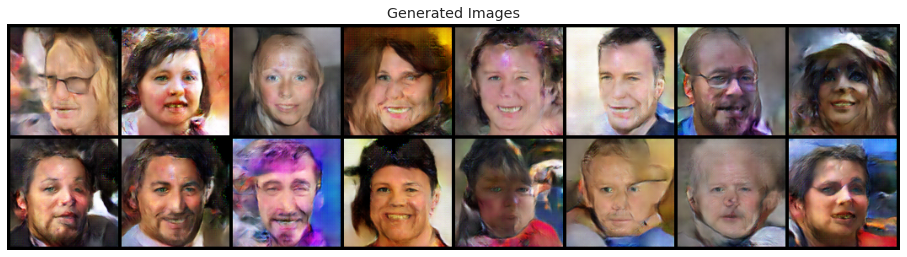

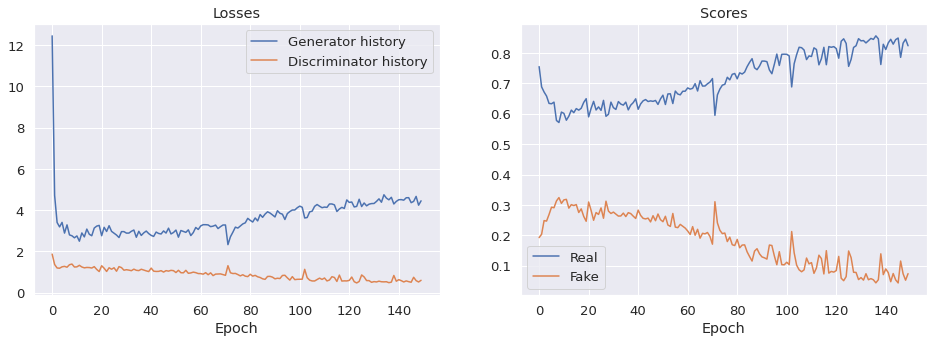

Epoch [150/150], loss_g: 4.4518, loss_d: 0.6003, real_score: 0.8235, fake_score: 0.0738


In [ ]:
epochs = 150
losses_g, losses_d, real_scores, fake_scores = fit(model, criterion, epochs, lr, loader)

In [ ]:
torch.save(model['discriminator'].state_dict(), '/kaggle/working/discriminator.pt')
torch.save(model['generator'].state_dict(), '/kaggle/working/generator.pt')

In [12]:
model['discriminator'].load_state_dict(torch.load('drive/MyDrive/discriminator.pt'))
model['generator'].load_state_dict(torch.load('drive/MyDrive/generator.pt'))

<All keys matched successfully>

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

По графикам видно, что две сети соревнуются между собой. Это понятно из уменьшающегося лосса дискриминатора и повышающегося лосса генератора. В самом начале обучения лосс генератора пададает до значения, при котором дискриминатор начинает ошибаться. Далее постепенно начинается процесс соревнования между сетями. Спустя несколько десятков эпох линии графика начинают расходиться, так как дискриминатор начинает обыгрывать генератор. Тем временем генератор периодически "проваливает" лосс, так как находит способ обхитрить дискриминатор. При увеличении числа эпох этот процесс переходит в состояние при котором оба попадают в локальные минимуму и их лоссы начинают колебаться вокруг некоторых значений, практически не изменяясь. Линии приобретают более коллинеарный вид.

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [13]:
n_images = 64

model["generator"].eval()
fixed_latent = torch.randn(n_images, latent_size, device=device)
fake_images = model["generator"](fixed_latent)

In [14]:
def show_images(generated):
    # TODO: show generated images
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(make_grid(generated[:64], padding=4, normalize=True).cpu(), (1,2,0)))

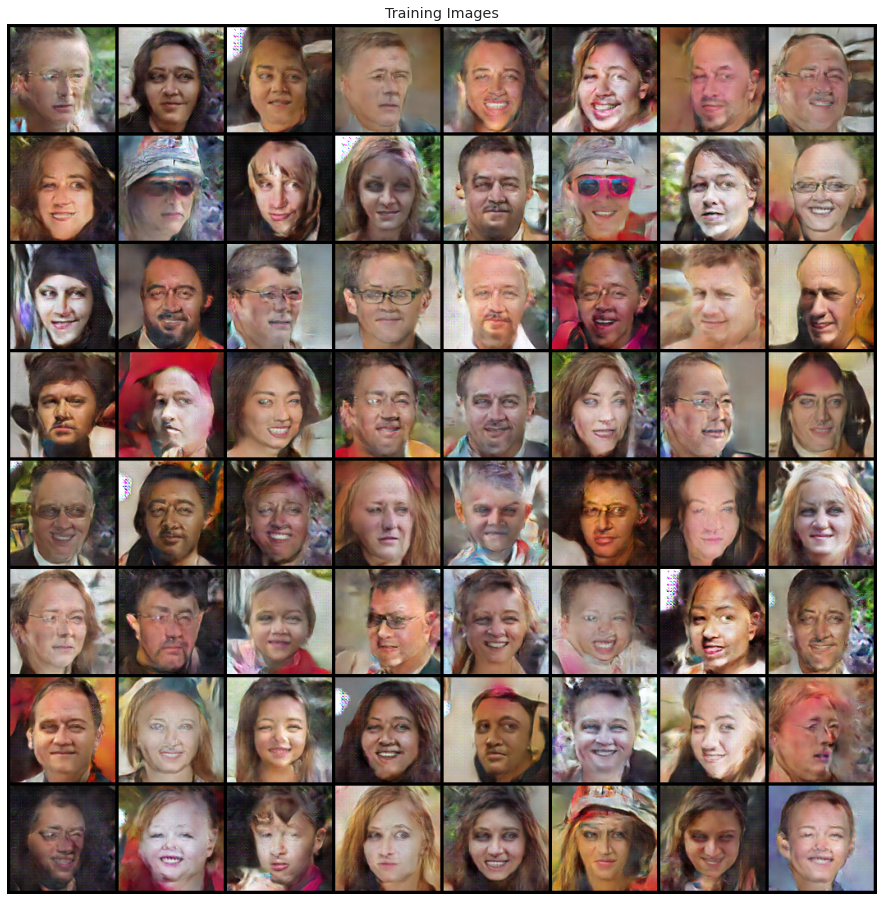

In [15]:
show_images(fake_images)

Как вам качество получившихся изображений?

Так как система динамическая качество плавает от эпохи к эпохе. Поэтому увелиение количества эпох может привести к невозможности генератора выйти за пределы локального минимума. Что ведет к чередованию качества изображений. Видно, что сами изображения отличаются от тех, чо сгенерированы вариационным автоэнкодером. В данном случае латентное пространство содержит разрозненные элементы из которых конструируются лица. В вариационном автоэнкодере изображения плавно перетекают друг в друга. Эта архитектура ведет себя более "творчески".

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
del losses_g
del losses_d
del real_scores
del fake_scores

In [16]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier

n = 512 #с полным датасетом слишком долго считает
fake_images = []
for i in range(n):
    fake_image = model["generator"].cpu()(torch.randn(1, latent_size)).detach()
    fake_images.append(fake_image)

fake_images = torch.vstack(fake_images)
fake_labels = torch.zeros(fake_images.size(0))
real_images = dataset[:n]
real_labels = torch.ones(real_images.size(0))

In [17]:
from sklearn.utils import shuffle
images, labels = shuffle(torch.cat([fake_images, real_images], 0),
                         torch.cat([fake_labels, real_labels], 0), random_state=0)

In [18]:
# from cuml.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier

X = images.reshape(2*n, -1).numpy()
y = labels.numpy()

loo = LeaveOneOut()
loo.get_n_splits(X)


acc = 0
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    knn1 = KNeighborsClassifier(n_neighbors=1)
    knn1.fit(X_train, y_train)
    y_hat = knn1.predict(X_test)
    acc += (y_hat == y_test).sum()

    del X_train
    del X_test
    del y_train
    del y_test
    del knn1
    del y_hat

acc /= 2 * n
acc

0.6279296875

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Значения близкие к 0.5 отражают случайный выбор между фейковым и настоящим изображением. Таким образом, если классификатор не может отличить эти изображения, то это говорит о хорошем качестве генерации фейков. Было проверено, что предлагаемая архитектура, обученная до 300й эпохи позволяет генрировать фейки, которые по точности приближаются к 0.55 для knn. Для 100 эпох результат хуже.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
from sklearn.manifold import TSNE

repr = TSNE().fit_transform(images.reshape(2*n, -1))

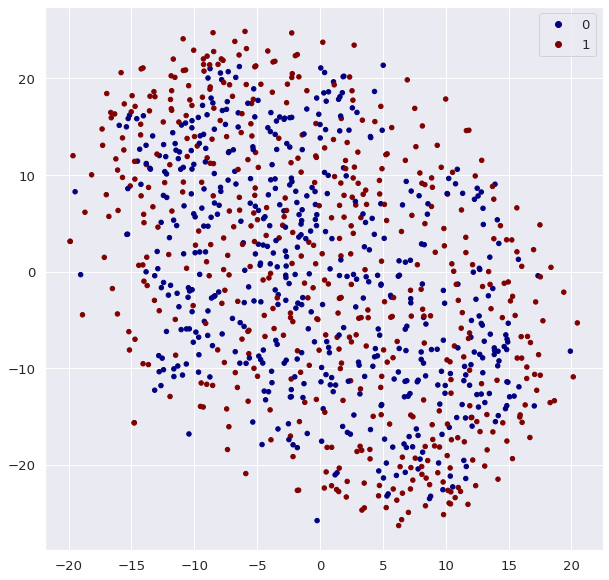

In [21]:
plt.figure(figsize=(10, 10))
scatter = plt.scatter(repr[:, 0], repr[:, 1], c=labels, s=20, cmap='jet')
plt.legend(*scatter.legend_elements())

Прокомментируйте получившийся результат:

Видно, что классы сложно различить, - они все расположены в одном кластере. Однако заметим, что границы облаков классов не сопадают. Реальные изображения имеют более широкие границы относительно центра кластера. 